## 1. Import Library 
___

### Install EfficientDet Library

In [1]:
!pip install -q git+https://github.com/rwightman/efficientdet-pytorch

  Preparing metadata (setup.py) ... done


In [2]:
import os 
import sys
import pickle
import random
import gc
import ctypes
import copy
from collections import defaultdict

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore
from PIL import Image
import cv2

import torch; import timm
print(f'{Fore.BLUE} => Pytorch Version: ', torch.__version__)
print(f'{Fore.BLUE} => Timm Version: ', timm.__version__)
import torch.nn as nn
from torch.cuda import amp
import torch.functional as F
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## EfficientDet Library
from effdet.efficientdet import EfficientDet, HeadNet, BiFpn
from effdet.bench import DetBenchTrain, DetBenchPredict
# default config: tf_efficientdet_d1
from effdet.config import get_efficientdet_config, default_detection_model_configs
from effdet.config import default_detection_train_config, get_fpn_config

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import warnings
warnings.filterwarnings('ignore')

print(f'{Fore.BLUE} => Installed Necessary Library')

 => Pytorch Version:  2.5.1+cu121
 => Timm Version:  1.0.12


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


 => Installed Necessary Library


### Configuration

In [3]:
class CFG:
    output_dir = 'runs/detect'
    seed = 2025

    img_size = [512, 512]
    imgdir = '/kaggle/input/gastroscopy-256x256-resized-png'
    model_name = 'tf_efficientdet_d1'
    num_classes = 3 # Ulcer, Polyp, Cancer

    num_epochs = 40
    train_bs = 4
    valid_bs = train_bs * 2 
    scheduler_type = 'CosineAnnealingLR' # ReduceLROnPlateau, CosineAnnealingWarmRestarts
    base_lr = 1e-3
    min_lr = 1e-9
    weight_decay = 1e-5
    T_mult = 1
    
    n_accumulate = 1 ## Gradient Accumulation
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device_count = torch.cuda.device_count()

print('Device is', CFG.device)
print('Num GPU of machine is', CFG.device_count)

Device is cuda
Num GPU of machine is 1


### Reproducibility

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

### Clean_memory

In [5]:
def clean_memory():
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()

clean_memory()

## 2. Utils
___

**draw_bbox**

In [6]:
def draw_bbox(image, box, label_name, label_id, color):
    alpha_text = 0.8 # text box color
    thickness = 2
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(str(label_id) + ' ' + label_name.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
    # Adding Text Box
    cv2.rectangle(overlay_text, (box[0],box[1]-text_height-5),
                  (box[0]+text_width, box[1]), color, -1)
    cv2.addWeighted(overlay_text, alpha_text, output, 1-alpha_text, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2],box[3]), color, thickness)
    cv2.putText(output, str(label_id) + ' ' + label_name.upper(), (box[0], box[1]-3),
               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

    return output

**AverageMeter**

In [7]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

**Collate_fn**

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

## 3. Build Dataset
___

In [9]:
df = pd.read_csv('/kaggle/input/gastroscopy-meta/gastroscopy_data2.csv')
print('Shape of DataFrame: ', df.shape)
print(display(df))

Shape of DataFrame:  (2915, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1257.45,738.30;1212.77,748.94;1168.09,748.94;1...",rectangle,763.829787,365.957447,1304.255319,748.936170,ulcer
1,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1421.28,955.32;1387.23,985.11;1368.09,1025.53;...",rectangle,1148.936170,897.872340,1421.276596,1082.978723,ulcer
2,1_1_00014.png,2048,2048,gastroscopy,0,1,polygon,"1065.96,1110.64;1040.43,1148.94;1010.64,1182.9...",rectangle,521.276596,561.702128,1078.723404,1225.531915,ulcer
3,1_1_00017.png,2048,2048,gastroscopy,0,1,polygon,"1246.30,514.89;1197.36,508.51;1154.81,502.13;1...",rectangle,884.595745,502.127660,1376.085106,753.191489,ulcer
4,1_1_00018.png,2048,2048,gastroscopy,0,1,polygon,"1397.36,389.36;1352.68,382.98;1314.38,404.26;1...",rectangle,1161.191489,382.978723,1654.808511,1074.468085,ulcer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,1_2_05234.png,2048,2048,gastroscopy,1,1,polygon,"1115.23,604.26;1066.30,604.26;1021.62,608.51;9...",rectangle,864.170213,604.255319,1506.723404,1340.425532,polyp
2911,1_2_05235.png,2048,2048,gastroscopy,1,1,polygon,"1138.64,1036.17;1096.09,1068.09;1064.17,1102.1...",rectangle,949.276596,1019.148936,1528.000000,1542.553191,polyp
2912,1_2_05236.png,2048,2048,gastroscopy,1,1,polygon,"619.49,529.79;583.32,555.32;553.53,591.49;532....",rectangle,523.744681,519.148936,766.297872,789.361702,polyp
2913,1_2_05236.png,2048,2048,gastroscopy,1,1,polygon,"672.68,1342.55;630.13,1355.32;606.72,1393.62;6...",rectangle,602.468085,1342.553191,759.914894,1493.617021,polyp


None


In [10]:
# Label Change: 0,1,2 -> 1,2,3
# EfficientDet AnchorLabler Class labels start from 1 and the background class = -1
# this class filter out (gt_class <= -1) 

df['lesion_label'] = df['lesion_label'] + 1

In [11]:
train_id = [x.split('/')[-1] for x in glob('/kaggle/input/gastroscopy-256x256-resized-png/train/*.png')] 
test_id = [x.split('/')[-1] for x in glob('/kaggle/input/gastroscopy-256x256-resized-png/test/*.png')] 

train_df = df[df['image_id'].isin(train_id)].reset_index(drop=True)
test_df = df[df['image_id'].isin(test_id)].reset_index(drop=True)

print('=> Number of Unique Image_id in Train: ', train_df.image_id.nunique())
print('=> Number of Unique Image_id in Test: ', test_df.image_id.nunique())

=> Number of Unique Image_id in Train:  1597
=> Number of Unique Image_id in Test:  400


In [12]:
gkf = GroupKFold(n_splits=5)

for i, (_, val_idx) in enumerate(gkf.split(train_df, groups=train_df['image_id'])):
    train_df.loc[val_idx, 'fold'] = i

valid_df = train_df[train_df['fold'] == 0].reset_index(drop=True)
train_df = train_df[train_df['fold'] != 0].reset_index(drop=True)

print('Images in train_df: ', train_df['image_id'].nunique())
print('Images in valid_df: ', valid_df['image_id'].nunique())

Images in train_df:  1279
Images in valid_df:  318


In [13]:
def get_train_transform():
    return A.Compose(
        [
         A.HorizontalFlip(p=0.5),   
         A.Resize(*CFG.img_size, p=1.0),
         ],
         bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )

def get_valid_transform():
    return A.Compose(
        [A.Resize(*CFG.img_size, p=1.0),
         ],
        bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


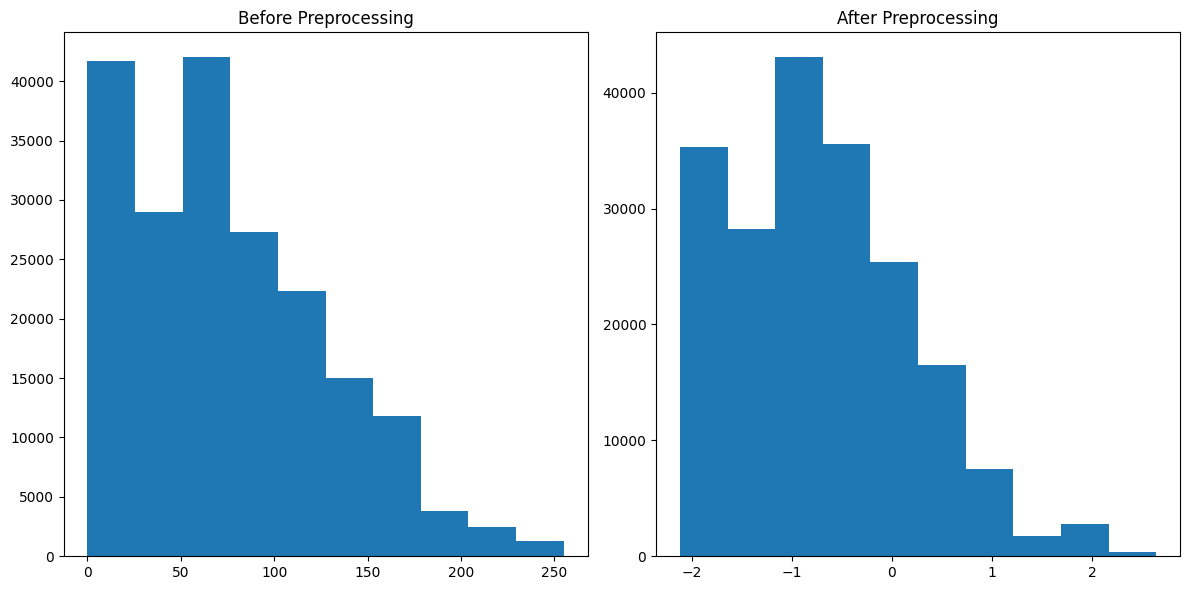

In [14]:
!pip install -q efficientnet

from efficientnet.keras import preprocess_input

path = '/kaggle/input/gastroscopy-256x256-resized-png/train/1_1_00011.png'
img = Image.open(path)
img = np.array(img)
img_preprocessed = preprocess_input(img)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Before Preprocessing')
plt.hist(img.flatten())

plt.subplot(1,2,2)
plt.title('After Preprocessing')
plt.hist(img_preprocessed.flatten())

plt.tight_layout()
plt.show()

In [15]:
### Bbox Format: Ymin, Xmin, Ymax, Xmax
### Image Preprocessing: Normalization

class GastroscopyDataset(Dataset):
    def __init__(self, df, image_dir=None, mode='train', transforms=None):
        super(GastroscopyDataset).__init__()

        self.image_ids = df['image_id'].unique()
        self.df = df
        self.mode = mode
        self.image_dir = image_dir
        self.transforms = transforms
        

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]

        image, boxes, labels = self.load_image_and_boxes(index)

        target= {}
        target['boxes'] = torch.tensor(boxes).to(torch.float32)
        target['labels'] = torch.tensor(labels).to(torch.int64)
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            sample = self.transforms(image=image, bboxes=boxes, labels=labels)

            if len(sample['bboxes']) > 0:
                image = sample['image']
                image = preprocess_input(image)
                image = torch.tensor(image.transpose(2,0,1).astype(np.float32))
                target['boxes'] = torch.tensor(sample['bboxes']).to(torch.float32)
                target['labels'] = torch.tensor(sample['labels']).to(torch.int64)
                # Xmin, Ymin, Xmax, Ymax => Ymin, Xmin, Ymax, Xmax
                target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]
            else: 
                image = preprocess_input(image)
                image = torch.tensor(image.transpose(2,0,1).astype(np.float32))
                target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]

        
        if self.mode == 'train':
            return image, target, image_id
        else:
            return image, image_id

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        path = os.path.join(f'{self.image_dir}', 'train', image_id)
        image = Image.open(path).resize((CFG.img_size[0], CFG.img_size[1]))
        image = np.array(image)
        resized_height, resized_width = image.shape[:2]
        
        ## FillNan
        m = np.nanmean(image)
        image = np.nan_to_num(image, nan=m)
        
        records = self.df[self.df['image_id'] == image_id]
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes[:,[0,2]] *= resized_width / records['width'].values[0] 
        boxes[:,[1,3]] *= resized_height / records['height'].values[0]
        
        labels = records['lesion_label'].values

        return image, boxes, labels

In [16]:
train_dataset = GastroscopyDataset(
         df = train_df, 
         image_dir = CFG.imgdir,
         transforms = get_train_transform()
)

valid_dataset = GastroscopyDataset(
         df = valid_df,
         image_dir = CFG.imgdir,
         transforms = get_valid_transform()
)

## 3. Visualization Gastroscopy Augmentation
___

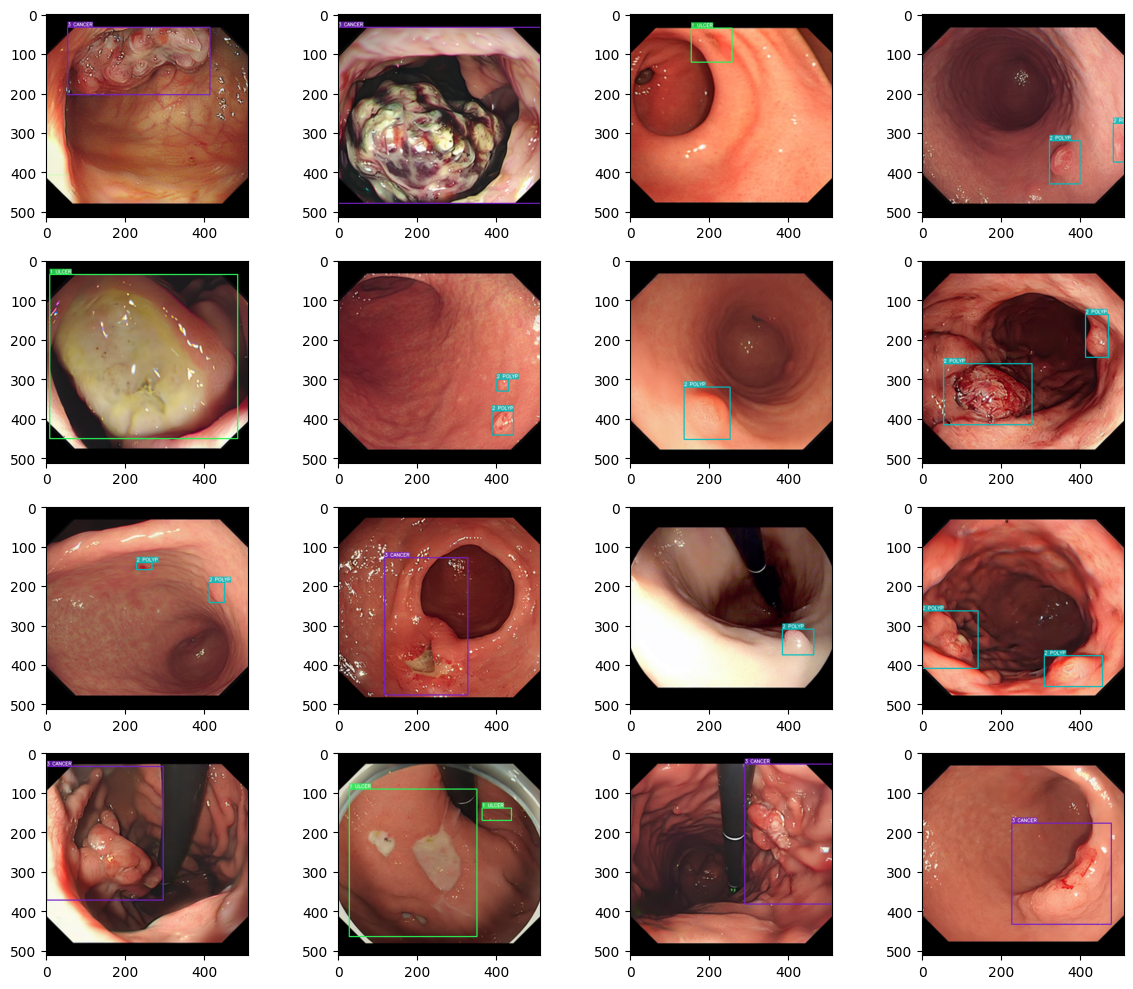

In [17]:
classes = {1: 'Ulcer', 2: 'Polyp', 3: 'Cancer'}

label2color = [[random.randint(0,255) for i in range(3)] for _ in range(CFG.num_classes)]

plt.style.use('default')
plt.figure(figsize=(12,10))

for i in range(16):
    j = np.random.randint(0, len(train_dataset), 1)[0]
    image, target, image_id = train_dataset[j]
    img = image.permute(1,2,0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    img = img*std + mean
    
    img = (img*255).astype('uint8')
    boxes = target['boxes'].cpu().numpy()
    boxes[:,[0,1,2,3]] = boxes[:,[1,0,3,2]]
    labels = target['labels'].cpu().numpy()

    plt.subplot(4,4,i+1)
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id - 1]
        img = draw_bbox(img, list(np.int_(box)), classes[label_id], label_id, color)
        plt.imshow(img)
        #plt.axis('off')
    clean_memory()
    del image, target, image_id
        
plt.tight_layout()
plt.show()

## 4. Build Trainer Engine
___

**Scheduler**

In [18]:
def fetch_scheduler(scheduler_type, optimizer, loader):
    if scheduler_type == 'ReduceLROnPlateau':  
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', verbose=False, factor=0.1, patience=20, threshold=1e-3,
            threshold_mode='abs', min_lr = CFG.min_lr
        )
        return scheduler
        
    elif scheduler_type == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=CFG.num_epochs*len(loader), eta_min=CFG.min_lr,
            last_epoch=-1, verbose=False
        )
        return scheduler
        
    elif scheduler_type == 'CosineAnnealingWarmRestarts':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0 = CFG.num_epochs*len(loader)//3, T_mult=CFG.T_mult, eta_min=CFG.min_lr,
            last_epoch=-1, verbose=False
        )
        return scheduler
        
    else:
        return None

**Build_model**

In [19]:
def build_model():
    config = get_efficientdet_config(model_name=CFG.model_name)
    config.num_classes = CFG.num_classes  
    config.image_size = CFG.img_size ## Image size should be divided by the largest feature stride 2^max_level
    config.max_det_per_image = 100
    
    config.fpn_name = 'bifpn_fa'
    config.fpn_cell_repeats = 3
    config.fpn_channels = 384

    # Multi Scale Config
    config.min_level = 3
    config.max_level = 7
    config.num_level = 5
    config.num_scales = 4 # intermediate scales added on each level [2^0, 2^0.33, 2^0.66]
    config.aspect_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)] #ratio w/h: 2.0 means w=1.4, h=0.7.
    config.anchor_scale = 4 # base_anchor: 2^level * 4 # [32, 64, 128, 256, 512]
    
    config.label_smoothing = 0.15

    net = EfficientDet(config, pretrained_backbone=True)
    net.box_net = HeadNet(config, num_outputs=4)
    net.class_net= HeadNet(config, num_outputs=config.num_classes)
    
    return DetBenchTrain(net, create_labeler=True)

In [20]:
class Trainer:
    def __init__(self, model, optimizer, scheduler, device, num_epochs, output_dir):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.num_epochs = num_epochs

        self.history = defaultdict(list)
        self.summary_loss = AverageMeter(); self.box_loss = AverageMeter(); self.class_loss = AverageMeter()
        self.val_summary_loss = AverageMeter(); self.val_box_loss = AverageMeter(); self.val_class_loss = AverageMeter()
        
        self.best_loss = 10**5
        self.best_epoch = 0
        
        self.output_dir = output_dir
        
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir, exist_ok=True)
            
        print(f'{Fore.BLUE} ### Trainer Prepared, Device is {self.device}')
    
    def fit(self, train_loader, valid_loader):

        for epoch in range(1, self.num_epochs + 1):
            print(f'{Fore.BLUE}#'*25)
            print(f'{Fore.BLUE}### Epoch {epoch}/{self.num_epochs}')
            print(f'{Fore.BLUE}#'*25)

            train_loss = self.train_one_epoch(train_loader)
            valid_loss = self.valid_one_epoch(valid_loader)

            print(f'{Fore.BLUE}Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')
            
            self.model.eval()
            last_model_wts = copy.deepcopy(self.model.model.state_dict())
            torch.save(last_model_wts, f'{self.output_dir}/last-checkpoint.bin')

            if valid_loss <= self.best_loss:
                self.best_loss = valid_loss
                self.best_epoch = epoch
                best_model_wts = copy.deepcopy(self.model.model.state_dict())

                torch.save(best_model_wts, f'{self.output_dir}/best-checkpoint.bin')
            
            self.model.model.load_state_dict(torch.load(f'{self.output_dir}/best-checkpoint.bin'))

        return self.model, self.history

    
    def train_one_epoch(self, train_loader):
        self.model.train()

        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Training')

        for step, (images, targets, image_ids) in pbar:
            images = torch.stack(images) ## Adding Batch Dimensional
            images = images.to(self.device).float()
            batch_size = images.size(0)

            target_res = {}
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target_res['bbox'] = boxes
            target_res['cls'] = labels

            output = self.model(images, target_res)

            loss = output['loss']; self.summary_loss.update(loss.detach().item(), batch_size)
            cls_loss = output['class_loss']; self.class_loss.update(cls_loss.detach().item(), batch_size)
            bx_loss = output['box_loss']; self.box_loss.update(bx_loss.detach().item(), batch_size)
            
            
            (loss / CFG.n_accumulate).backward()

            if (step + 1) % CFG.n_accumulate == 0:
            
               self.optimizer.step()

               self.optimizer.zero_grad()

               if CFG.scheduler_type == 'ReduceLROnPlateau': 
                   self.scheduler.step(metrics=self.summary_loss.avg)
               else:
                   self.scheduler.step()

            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

            self.history['total_loss'].append(self.summary_loss.avg)
            self.history['box_loss'].append(self.box_loss.avg)
            self.history['class_loss'].append(self.class_loss.avg)
            self.history['LR'].append(self.optimizer.param_groups[0]["lr"])
        
            pbar.set_postfix(
                  total_loss = f'{self.summary_loss.avg:.5f}',
                  cls_loss = f'{self.class_loss.avg:.5f}', 
                  box_loss = f'{self.box_loss.avg:.5f}',
                  lr = f'{self.optimizer.param_groups[0]["lr"]:.9f}',
                  gpu_mem = f'{mem} GB'
             )
        
        torch.cuda.empty_cache()
        clean_memory()
        
        return self.summary_loss.avg

    @torch.no_grad()
    def valid_one_epoch(self, valid_loader):
        self.model.eval()

        pbar = tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation')
        for step, (images, targets, image_ids) in pbar:
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.size(0)

                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets] 

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels
                target_res['img_scale'] = torch.tensor([1.0]*batch_size, 
                                                       dtype=torch.float).to(self.device) 
                target_res['img_size'] = torch.tensor([images[0].shape[-2:]]*batch_size,
                                                       dtype=torch.float).to(self.device)
                output = self.model(images, target_res)
                loss = output['loss']; self.val_summary_loss.update(loss.detach().item(), batch_size)
                cls_loss = output['class_loss']; self.val_class_loss.update(cls_loss.detach().item(), batch_size)
                bx_loss = output['box_loss']; self.val_box_loss.update(bx_loss.detach().item(), batch_size)
            
                mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

                self.history['valid_total_loss'].append(self.val_summary_loss.avg)
                self.history['valid_box_loss'].append(self.val_box_loss.avg)
                self.history['valid_class_loss'].append(self.val_class_loss.avg)
                
                pbar.set_postfix(
                     valid_total_loss = f'{self.val_summary_loss.avg:.5f}',
                     valid_cls_loss = f'{self.val_class_loss.avg:.5f}', 
                     valid_box_loss = f'{self.val_box_loss.avg:.5f}',
                     lr = f'{self.optimizer.param_groups[0]["lr"]:.9f}',
                     gpu_mem = f'{mem} GB'
                )
        
        torch.cuda.empty_cache()
        clean_memory()
        
        return self.val_summary_loss.avg

In [21]:
def run_training(train_loader, valid_loader):

    model = build_model()

    model.to(CFG.device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.base_lr, weight_decay=CFG.weight_decay)
    scheduler = fetch_scheduler(CFG.scheduler_type, optimizer, train_loader)
    
    trainer = Trainer(model=model, optimizer=optimizer, scheduler=scheduler, 
            device=CFG.device, num_epochs=CFG.num_epochs, output_dir=CFG.output_dir)

    best_model, history = trainer.fit(train_loader, valid_loader)
    
    del train_loader, valid_loader
    clean_memory()
    
    return best_model, history
    

In [22]:
train_loader = DataLoader(
        train_dataset,
        batch_size = CFG.train_bs,
        shuffle = True,
        drop_last = False,
        pin_memory = True,
        collate_fn = collate_fn,
    )
    
valid_loader = DataLoader(
        valid_dataset,
        batch_size = CFG.valid_bs,
        shuffle = False,
        drop_last = False,
        pin_memory = True,
        collate_fn = collate_fn 
    )

In [23]:
best_model, history = run_training(train_loader, valid_loader)

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

 ### Trainer Prepared, Device is cuda
#########################
### Epoch 1/40
#########################


Validation: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s, gpu_mem=1.052770304 GB, lr=0.000998459, valid_box_loss=0.00766, valid_cls_loss=2.65303, valid_total_loss=3.03588]


Train Loss: 32.7541 | Valid Loss: 3.0359
#########################
### Epoch 2/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.68it/s, gpu_mem=1.149239296 GB, lr=0.000993844, valid_box_loss=0.00727, valid_cls_loss=1.67857, valid_total_loss=2.04230]


Train Loss: 16.9613 | Valid Loss: 2.0423
#########################
### Epoch 3/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.75it/s, gpu_mem=1.155530752 GB, lr=0.000986185, valid_box_loss=0.00679, valid_cls_loss=1.33385, valid_total_loss=1.67332]


Train Loss: 11.6175 | Valid Loss: 1.6733
#########################
### Epoch 4/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.70it/s, gpu_mem=1.168113664 GB, lr=0.000975528, valid_box_loss=0.00650, valid_cls_loss=1.14424, valid_total_loss=1.46917]


Train Loss: 8.9204 | Valid Loss: 1.4692
#########################
### Epoch 5/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.74it/s, gpu_mem=1.16391936 GB, lr=0.000961940, valid_box_loss=0.00623, valid_cls_loss=1.02990, valid_total_loss=1.34122]


Train Loss: 7.2863 | Valid Loss: 1.3412
#########################
### Epoch 6/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.72it/s, gpu_mem=1.172307968 GB, lr=0.000945503, valid_box_loss=0.00602, valid_cls_loss=0.94312, valid_total_loss=1.24399]


Train Loss: 6.1853 | Valid Loss: 1.2440
#########################
### Epoch 7/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.73it/s, gpu_mem=1.166016512 GB, lr=0.000926320, valid_box_loss=0.00585, valid_cls_loss=0.88248, valid_total_loss=1.17506]


Train Loss: 5.3896 | Valid Loss: 1.1751
#########################
### Epoch 8/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.73it/s, gpu_mem=1.168113664 GB, lr=0.000904509, valid_box_loss=0.00574, valid_cls_loss=0.83677, valid_total_loss=1.12370]


Train Loss: 4.7874 | Valid Loss: 1.1237
#########################
### Epoch 9/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.72it/s, gpu_mem=1.168113664 GB, lr=0.000880203, valid_box_loss=0.00563, valid_cls_loss=0.80248, valid_total_loss=1.08403]


Train Loss: 4.3139 | Valid Loss: 1.0840
#########################
### Epoch 10/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.72it/s, gpu_mem=1.170210816 GB, lr=0.000853554, valid_box_loss=0.00556, valid_cls_loss=0.77943, valid_total_loss=1.05734]


Train Loss: 3.9331 | Valid Loss: 1.0573
#########################
### Epoch 11/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s, gpu_mem=1.170210816 GB, lr=0.000824724, valid_box_loss=0.00551, valid_cls_loss=0.75808, valid_total_loss=1.03378]


Train Loss: 3.6159 | Valid Loss: 1.0338
#########################
### Epoch 12/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.81it/s, gpu_mem=1.170210816 GB, lr=0.000793893, valid_box_loss=0.00545, valid_cls_loss=0.73868, valid_total_loss=1.01139]


Train Loss: 3.3504 | Valid Loss: 1.0114
#########################
### Epoch 13/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.77it/s, gpu_mem=1.168113664 GB, lr=0.000761250, valid_box_loss=0.00545, valid_cls_loss=0.72455, valid_total_loss=0.99686]


Train Loss: 3.1208 | Valid Loss: 0.9969
#########################
### Epoch 14/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.74it/s, gpu_mem=1.170210816 GB, lr=0.000726996, valid_box_loss=0.00540, valid_cls_loss=0.71234, valid_total_loss=0.98251]


Train Loss: 2.9237 | Valid Loss: 0.9825
#########################
### Epoch 15/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.77it/s, gpu_mem=1.166016512 GB, lr=0.000691342, valid_box_loss=0.00535, valid_cls_loss=0.69985, valid_total_loss=0.96746]


Train Loss: 2.7492 | Valid Loss: 0.9675
#########################
### Epoch 16/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.74it/s, gpu_mem=1.168113664 GB, lr=0.000654509, valid_box_loss=0.00532, valid_cls_loss=0.69251, valid_total_loss=0.95847]


Train Loss: 2.5956 | Valid Loss: 0.9585
#########################
### Epoch 17/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.69it/s, gpu_mem=1.170210816 GB, lr=0.000616723, valid_box_loss=0.00529, valid_cls_loss=0.68617, valid_total_loss=0.95076]


Train Loss: 2.4583 | Valid Loss: 0.9508
#########################
### Epoch 18/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.72it/s, gpu_mem=1.170210816 GB, lr=0.000578218, valid_box_loss=0.00526, valid_cls_loss=0.67773, valid_total_loss=0.94049]


Train Loss: 2.3355 | Valid Loss: 0.9405
#########################
### Epoch 19/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.66it/s, gpu_mem=1.168113664 GB, lr=0.000539230, valid_box_loss=0.00523, valid_cls_loss=0.67276, valid_total_loss=0.93426]


Train Loss: 2.2244 | Valid Loss: 0.9343
#########################
### Epoch 20/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.72it/s, gpu_mem=1.172307968 GB, lr=0.000500001, valid_box_loss=0.00521, valid_cls_loss=0.66824, valid_total_loss=0.92861]


Train Loss: 2.1246 | Valid Loss: 0.9286
#########################
### Epoch 21/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.72it/s, gpu_mem=1.168113664 GB, lr=0.000460771, valid_box_loss=0.00518, valid_cls_loss=0.66474, valid_total_loss=0.92375]


Train Loss: 2.0322 | Valid Loss: 0.9237
#########################
### Epoch 22/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.70it/s, gpu_mem=1.166016512 GB, lr=0.000421783, valid_box_loss=0.00516, valid_cls_loss=0.66365, valid_total_loss=0.92178]


Train Loss: 1.9477 | Valid Loss: 0.9218
#########################
### Epoch 23/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.67it/s, gpu_mem=1.166016512 GB, lr=0.000383278, valid_box_loss=0.00514, valid_cls_loss=0.66159, valid_total_loss=0.91859]


Train Loss: 1.8699 | Valid Loss: 0.9186
#########################
### Epoch 24/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s, gpu_mem=1.170210816 GB, lr=0.000345492, valid_box_loss=0.00512, valid_cls_loss=0.66253, valid_total_loss=0.91866]


Train Loss: 1.7979 | Valid Loss: 0.9187
#########################
### Epoch 25/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s, gpu_mem=1.168113664 GB, lr=0.000308659, valid_box_loss=0.00510, valid_cls_loss=0.66343, valid_total_loss=0.91862]


Train Loss: 1.7313 | Valid Loss: 0.9186
#########################
### Epoch 26/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.75it/s, gpu_mem=1.166016512 GB, lr=0.000273005, valid_box_loss=0.00509, valid_cls_loss=0.66324, valid_total_loss=0.91761]


Train Loss: 1.6699 | Valid Loss: 0.9176
#########################
### Epoch 27/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s, gpu_mem=1.168113664 GB, lr=0.000238751, valid_box_loss=0.00507, valid_cls_loss=0.66394, valid_total_loss=0.91768]


Train Loss: 1.6122 | Valid Loss: 0.9177
#########################
### Epoch 28/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.70it/s, gpu_mem=1.170210816 GB, lr=0.000206108, valid_box_loss=0.00506, valid_cls_loss=0.66511, valid_total_loss=0.91806]


Train Loss: 1.5587 | Valid Loss: 0.9181
#########################
### Epoch 29/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.77it/s, gpu_mem=1.168113664 GB, lr=0.000175277, valid_box_loss=0.00505, valid_cls_loss=0.66556, valid_total_loss=0.91789]


Train Loss: 1.5089 | Valid Loss: 0.9179
#########################
### Epoch 30/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.77it/s, gpu_mem=1.166016512 GB, lr=0.000146447, valid_box_loss=0.00503, valid_cls_loss=0.66625, valid_total_loss=0.91797]


Train Loss: 1.4623 | Valid Loss: 0.9180
#########################
### Epoch 31/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s, gpu_mem=1.166016512 GB, lr=0.000119798, valid_box_loss=0.00502, valid_cls_loss=0.66654, valid_total_loss=0.91761]


Train Loss: 1.4186 | Valid Loss: 0.9176
#########################
### Epoch 32/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s, gpu_mem=1.168113664 GB, lr=0.000095492, valid_box_loss=0.00501, valid_cls_loss=0.66613, valid_total_loss=0.91653]


Train Loss: 1.3777 | Valid Loss: 0.9165
#########################
### Epoch 33/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.77it/s, gpu_mem=1.168113664 GB, lr=0.000073681, valid_box_loss=0.00500, valid_cls_loss=0.66667, valid_total_loss=0.91656]


Train Loss: 1.3388 | Valid Loss: 0.9166
#########################
### Epoch 34/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.75it/s, gpu_mem=1.168113664 GB, lr=0.000054498, valid_box_loss=0.00499, valid_cls_loss=0.66720, valid_total_loss=0.91656]


Train Loss: 1.3021 | Valid Loss: 0.9166
#########################
### Epoch 35/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.74it/s, gpu_mem=1.168113664 GB, lr=0.000038061, valid_box_loss=0.00498, valid_cls_loss=0.66744, valid_total_loss=0.91628]


Train Loss: 1.2675 | Valid Loss: 0.9163
#########################
### Epoch 36/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.78it/s, gpu_mem=1.166016512 GB, lr=0.000024473, valid_box_loss=0.00497, valid_cls_loss=0.66795, valid_total_loss=0.91627]


Train Loss: 1.2347 | Valid Loss: 0.9163
#########################
### Epoch 37/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.71it/s, gpu_mem=1.166016512 GB, lr=0.000013816, valid_box_loss=0.00496, valid_cls_loss=0.66876, valid_total_loss=0.91658]


Train Loss: 1.2036 | Valid Loss: 0.9166
#########################
### Epoch 38/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.71it/s, gpu_mem=1.168113664 GB, lr=0.000006157, valid_box_loss=0.00495, valid_cls_loss=0.66937, valid_total_loss=0.91672]


Train Loss: 1.1741 | Valid Loss: 0.9167
#########################
### Epoch 39/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.77it/s, gpu_mem=1.168113664 GB, lr=0.000001542, valid_box_loss=0.00494, valid_cls_loss=0.66981, valid_total_loss=0.91673]


Train Loss: 1.1461 | Valid Loss: 0.9167
#########################
### Epoch 40/40
#########################


Validation: 100%|██████████| 40/40 [00:10<00:00,  3.83it/s, gpu_mem=1.166016512 GB, lr=0.000000001, valid_box_loss=0.00493, valid_cls_loss=0.67033, valid_total_loss=0.91687]


Train Loss: 1.1196 | Valid Loss: 0.9169


**Learning Rate**

Scheduler Type is : CosineAnnealingLR
First Learning Rate is : 0.001
Last Learning Rate is : 1e-09
Iteration is:  12800


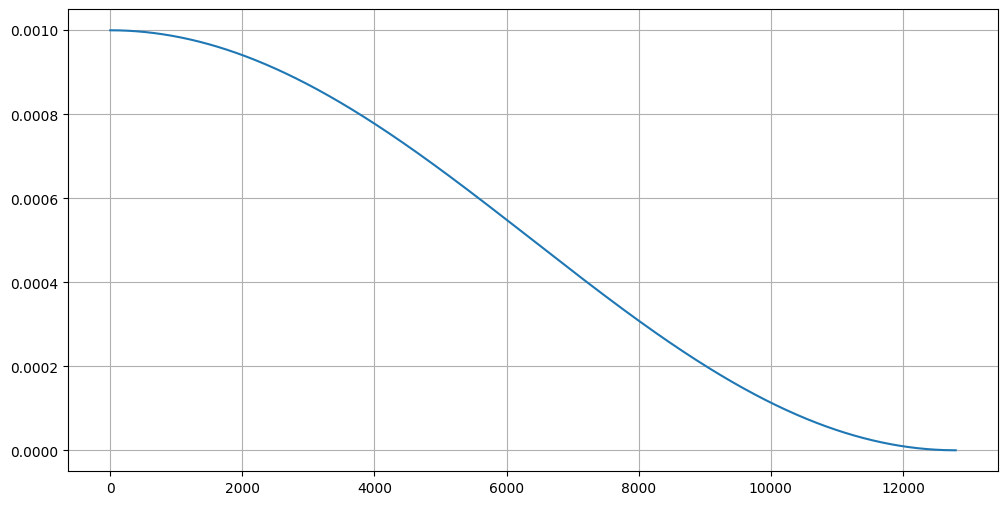

In [24]:
print('Scheduler Type is :', CFG.scheduler_type)
print('First Learning Rate is :', CFG.base_lr)
print('Last Learning Rate is :', history['LR'][-1])
print('Iteration is: ', len(history['LR']))

plt.figure(figsize=(12,6))

plt.plot(history['LR'])

plt.grid(True)
plt.show()

**Train Loss**

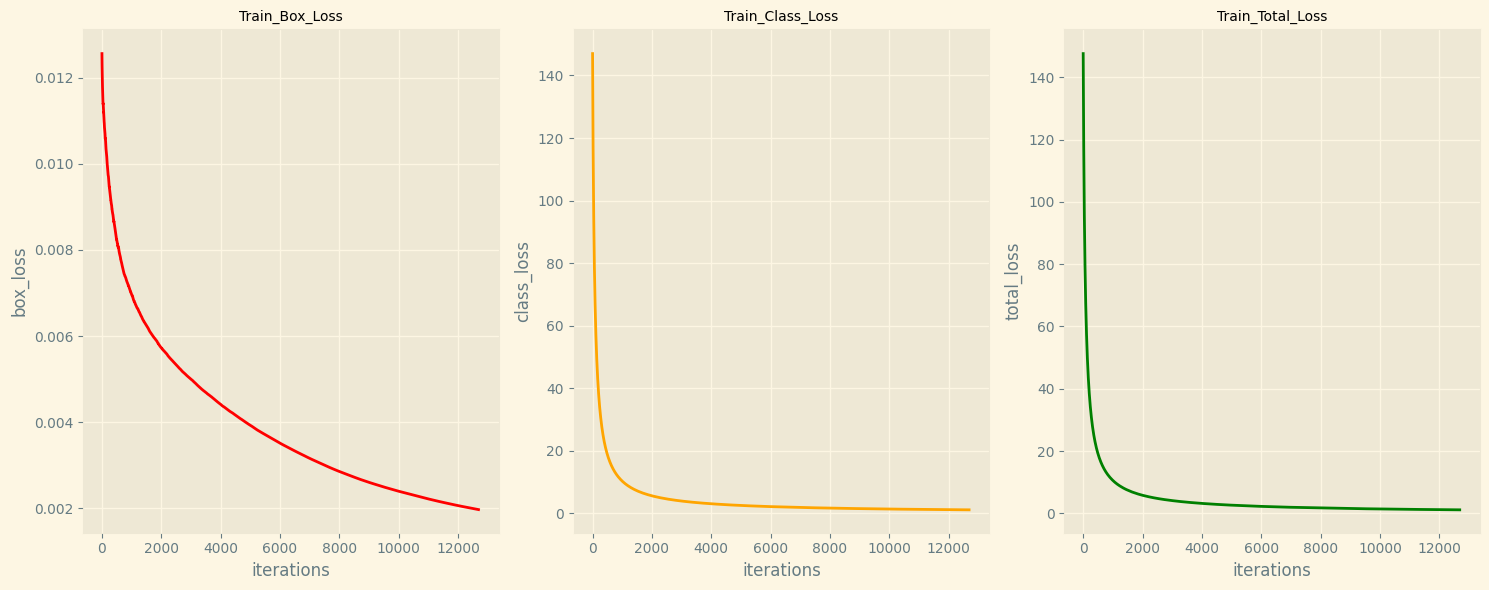

In [25]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.title('Train_Box_Loss', size=10)
plt.plot(history['box_loss'][len(train_loader)//5:], color='red')
plt.xlabel('iterations')
plt.ylabel('box_loss')
plt.grid(True)

plt.subplot(1,3,2)
plt.title('Train_Class_Loss', size=10)
plt.plot(history['class_loss'][len(train_loader)//5:], color='orange')
plt.xlabel('iterations')
plt.ylabel('class_loss')
plt.grid(True)

plt.subplot(1,3,3)
plt.title('Train_Total_Loss', size=10)
plt.plot(history['total_loss'][len(train_loader)//5:], color='green')
plt.xlabel('iterations')
plt.ylabel('total_loss')
plt.grid(True)

plt.tight_layout()
plt.show()

**Valid Loss**

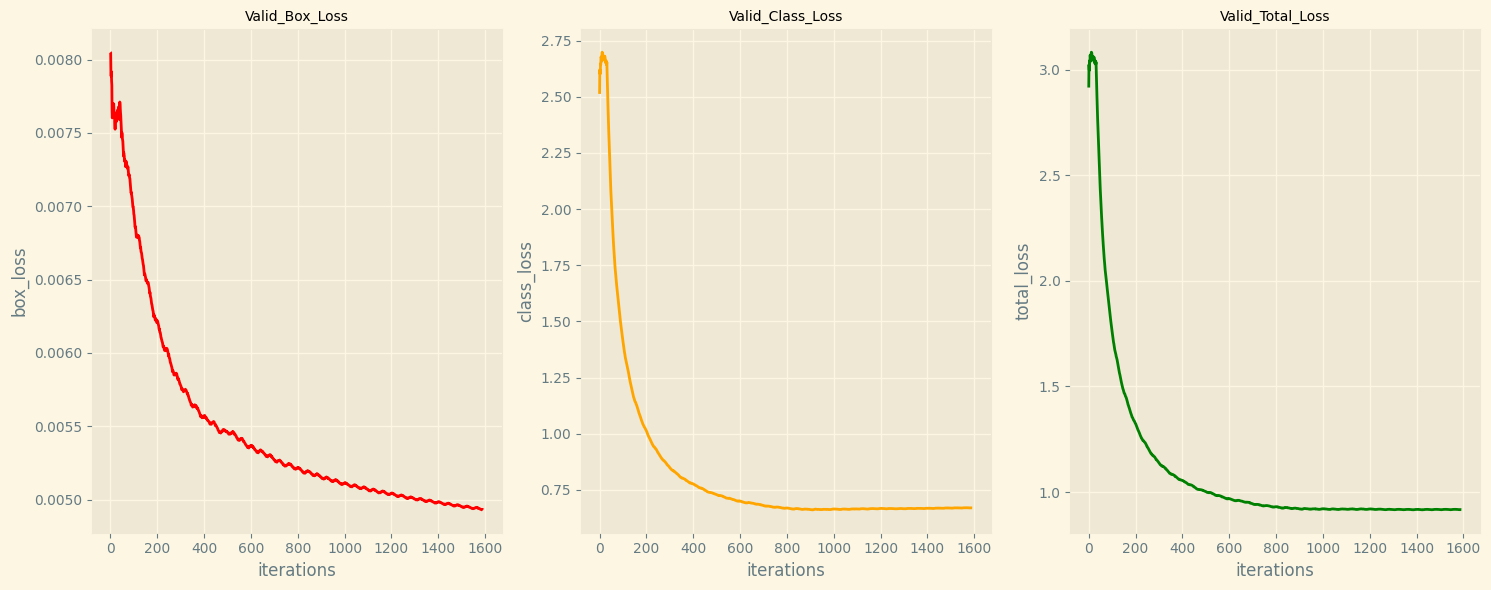

In [26]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.title('Valid_Box_Loss', size=10)
plt.plot(history['valid_box_loss'][len(valid_loader)//5:], color='red')
plt.xlabel('iterations')
plt.ylabel('box_loss')
plt.grid(True)

plt.subplot(1,3,2)
plt.title('Valid_Class_Loss', size=10)
plt.plot(history['valid_class_loss'][len(valid_loader)//5:], color='orange')
plt.xlabel('iterations')
plt.ylabel('class_loss')
plt.grid(True)

plt.subplot(1,3,3)
plt.title('Valid_Total_Loss', size=10)
plt.plot(history['valid_total_loss'][len(valid_loader)//5:], color='green')
plt.xlabel('iterations')
plt.ylabel('total_loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [27]:
clean_memory()
del train_loader, valid_loader, best_model, history

## 5. Validation
___

1) **Training**: `DetBenchTrain(net, config)` 

2) **Inference**: `DetBenchPredict(net, config)`

In [28]:
def load_net(checkpoint_path):
    config = get_efficientdet_config(model_name=CFG.model_name)
    config.num_classes = CFG.num_classes
    config.image_size = CFG.img_size
    config.max_det_per_image = 100
    
    config.fpn_name = 'bifpn_fa'
    config.fpn_cell_repeats = 3
    config.fpn_channels = 384
 
    ## Multi Scale Config 
    config.min_level = 3
    config.max_level = 7
    config.num_level = 5
    config.num_scales = 4 # intermediate scales added on each level [2^0, 2^0.33, 2^0.66]
    config.aspect_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)] #ratio w/h: 2.0 means w=1.4, h=0.7.
    config.anchor_scale = 4 # base_anchor: 2^level * 4 # [32, 64, 128, 256, 512]

    config.label_smoothing = 0.15

    net = EfficientDet(config, pretrained_backbone=False)
    net.box_net = HeadNet(config, num_outputs=4)
    net.class_net= HeadNet(config, num_outputs=config.num_classes)
    
    net.load_state_dict(torch.load(checkpoint_path))
    
    net = DetBenchPredict(net)

    return net

In [29]:
def format_pred(boxes, scores, labels):
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.float32)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)

In [30]:
def string_decoder(predict_string):
    s = predict_string.split(' ')
    class_id = [x for x in (s[0::6])]
    score = [x for x in (s[1::6])]
    x_min = [x for x in (s[2::6])]
    y_min = [x for x in (s[3::6])]
    x_max = [x for x in (s[4::6])]
    y_max = [x for x in (s[5::6])]

    return class_id, score, x_min, y_min, x_max, y_max

**Box Format**

1) EfficientDet의 학습 bbox format: `ymin, xmin, ymax, xmax`

2) EfficientDet의 출력 bbox format: `xmin, ymin, xmin, ymin`

In [31]:
def make_predictions(images, score_threshold=0.0):
    images = torch.stack(images).to(CFG.device).float()
    
    net = load_net('/kaggle/working/runs/detect/best-checkpoint.bin')
    net.to(CFG.device)
    net.eval()

    img_info = {}
    img_info['img_scale'] = torch.tensor([1] * images.shape[0], dtype=torch.float).to(CFG.device)
    img_info['img_size'] = torch.tensor([images[0].shape[-2:]] * images.shape[0], dtype=torch.float).to(CFG.device)

    predictions = []
    with torch.no_grad():
        
        det = net(images, img_info)
        for i in range(images.shape[0]):
            boxes = det[i].cpu().numpy()[:,:4]
            scores = det[i].cpu().numpy()[:,4]
            labels = det[i].cpu().numpy()[:,5].astype('int32')
            
            indexes = np.where(scores >= score_threshold)
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes],
            })
    return predictions    

In [32]:
valid_dataset = GastroscopyDataset(
         df = valid_df,
         mode = 'test', 
         image_dir = CFG.imgdir,
         transforms = get_valid_transform()
)

valid_loader = DataLoader(
        valid_dataset,
        batch_size = CFG.valid_bs,
        shuffle = False,
        drop_last = False,
        pin_memory = True,
        collate_fn = collate_fn 
    )

results = []

for images, image_ids in tqdm(valid_loader, total=len(valid_loader)):
    predictions = make_predictions(images)
    for i, image in enumerate(images):
        boxes = predictions[i]['boxes']
        scores = predictions[i]['scores']
        labels = predictions[i]['labels']
        image_id = image_ids[i]

        result = {
             'image_id': image_id,
             'PredictionString': format_pred(boxes, scores, labels)
                 }
        results.append(result)

100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


In [33]:
submission_det = pd.DataFrame(results, columns=['image_id','PredictionString'])
print(display(submission_det))

,image_id,PredictionString
0,1_1_00011.png,1 0.9398002028465271 97.99967956542969 59.9053...
1,1_1_00019.png,1 0.9697679281234741 10.585418701171875 39.661...
2,1_1_00029.png,1 0.9914577603340149 8.276901245117188 32.1497...
3,1_1_00042.png,1 0.6846641898155212 174.67230224609375 99.925...
4,1_1_00050.png,1 0.8466492891311646 92.89390563964844 255.541...
...,...,...
313,1_2_04981.png,2 0.9979487061500549 306.95562744140625 241.93...
314,1_2_05214.png,2 0.853199303150177 85.79607391357422 228.1726...
315,1_2_05221.png,2 0.9942533373832703 98.37406921386719 154.524...
316,1_2_05228.png,2 0.9963087439537048 306.8673400878906 199.715...


None


In [34]:
submission_list = []

for i, row in tqdm(submission_det.iterrows(), total=len(submission_det)):
    image_id = row['image_id']
    string_decoded = string_decoder(row['PredictionString'])

    for  (class_id, score, xmin, ymin, xmax, ymax) in zip(*string_decoded):
        submission_list.append(
            {
                'image_id': image_id,
                'lesion_label': int(class_id),
                'score': float(score),
                'x_min': float(xmin),
                'y_min': float(ymin),
                'x_max': float(xmax),
                'y_max': float(ymax),
                }
        )

submission_metric = pd.DataFrame(submission_list, columns=['image_id', 'lesion_label', 'score','x_min','y_min', 'x_max', 'y_max'])

100%|██████████| 318/318 [00:00<00:00, 2679.24it/s]


In [35]:
!pip install map-boxes
from map_boxes import mean_average_precision_for_boxes

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


In [36]:
ann = valid_df.copy()
det = submission_metric.copy()

ann['lesion_label'] -=1 ; det['lesion_label'] -= 1
ann['x_min'] *= CFG.img_size[0]/ann['width'].values[0]; ann['x_max'] *= CFG.img_size[0]/ann['width'].values[0]
ann['y_min'] *= CFG.img_size[1]/ann['height'].values[0]; ann['y_max'] *= CFG.img_size[1]/ann['height'].values[0]


ann = ann[['image_id','lesion_label','x_min','x_max','y_min','y_max']].values

det = det[['image_id','lesion_label', 'score','x_min','x_max','y_min','y_max']].values

mean_ap_50, average_precisions_50 = mean_average_precision_for_boxes(ann, det, iou_threshold=0.5)
mean_ap_75, average_precisions_75 = mean_average_precision_for_boxes(ann, det, iou_threshold=0.75)

Number of files in annotations: 318
Number of files in predictions: 318
Unique classes: 3
Detections length: 318
Annotations length: 318
0                              | 0.638820 |     101
1                              | 0.730367 |     171
2                              | 0.837089 |     181
mAP: 0.735425
Number of files in annotations: 318
Number of files in predictions: 318
Unique classes: 3
Detections length: 318
Annotations length: 318
0                              | 0.267926 |     101
1                              | 0.410716 |     171
2                              | 0.501223 |     181
mAP: 0.393288
